In [1]:
import numpy as np
import pandas as pd

In [3]:
owid_covid19 = pd.read_csv('./dataset/OWID/owid-covid-data.csv')
owid_covid19.head(2) 

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [18]:
owid_covid19_spain=owid_covid19.query('location=="Spain"')[22:]
day_num=list(range(1,owid_covid19_spain.shape[0]+1))
owid_covid19_spain['day_num']=day_num
owid_covid19_spain.head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,day_num
33360,ESP,Europe,Spain,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,1
33361,ESP,Europe,Spain,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,2


In [15]:
from pmdarima import auto_arima

In [33]:
def arima_cp(all_data,  target, train_lim, test_lim):
    
    #Select data for the Country/Region, splitting train/test days
    data_cp_train = all_data.loc[(all_data['day_num'])<=train_lim, target].astype(np.int32)
    data_cp_test = all_data.loc[(all_data['day_num'])>test_lim, target].astype(np.int32)

    # Set the range of parameters to use
    stepwise_model = auto_arima(all_data[target], start_p=1, start_q=1, max_p=30, max_q=30, 
                                start_P=0, seasonal=False, d=2, trace=False, error_action='ignore', stepwise=True)

    # Train and predict
    stepwise_model.fit(data_cp_train, start_ar_lags=2*max(30, 30))
    forecast = stepwise_model.predict(n_periods=test_lim-train_lim)
    return forecast,data_cp_train

In [35]:
forecast,train=arima_cp(owid_covid19_spain,  'total_cases', 90, 130)

C:\Users\syf19\Envs\covd19\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\syf19\Envs\covd19\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\syf19\Envs\covd19\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\syf19\Envs\covd19\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\syf19\Envs\covd19\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\syf

C:\Users\syf19\Envs\covd19\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\syf19\Envs\covd19\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\syf19\Envs\covd19\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\syf19\Envs\covd19\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\syf19\Envs\covd19\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood opt

In [36]:
print(train)

33360         0
33361         0
33362         0
33363         0
33364         0
          ...  
33445    186311
33446    190129
33447    193965
33448    193252
33449    195470
Name: total_cases, Length: 90, dtype: int32


In [37]:
# Plot the actual values vs predictions
def plot_arima_country(all_data, train, forecast, valid_num):
    df_train = train
    df_fcst = np.append(df_train[:-valid_num], forecast[:valid_num])
    dates = list(range(0,len(df_train)))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
    ax1.plot(dates, df_fcst)
    ax1.plot(dates, df_train)
    ax1.axvline(len(df_train)-valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    #ax1.set_title("Actual ConfirmedCases vs predictions based on ARIMA for "+country_name + "/"+province_name)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on January 22nd")
    ax1.set_ylabel("ConfirmedCases")

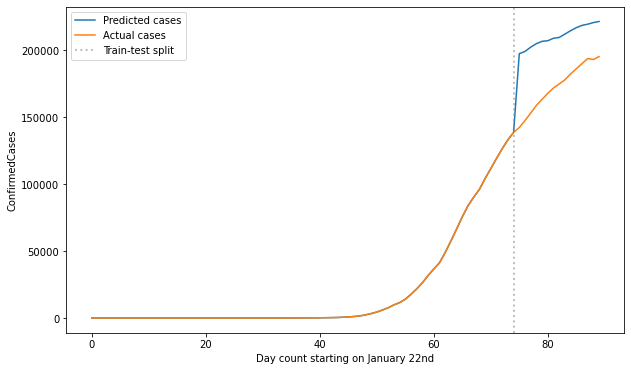

In [38]:
import matplotlib.pyplot as plt
train_lim = 69
valid_lim = 84 # needs to be changed as more days of training data are included
test_lim = 112
valid_num=valid_lim-train_lim 
plot_arima_country(owid_covid19_spain, train, forecast, valid_num)